In [17]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
run = 'imagenettewoof'
dataset = 'ImagenetteWoof'
first_split = pd.concat([pd.read_csv(f'predictions/{dataset}/{run}/first-split/{f}') for f in os.listdir(f'predictions/{dataset}/{run}/first-split')])
second_split = pd.concat([pd.read_csv(f'predictions/{dataset}/{run}/second-split/{f}') for f in os.listdir(f'predictions/{dataset}/{run}/second-split')])
first_split

,image_id,stage,epoch,label,prediction,loss,conf
0,500,first-split,3,0.0,0.0,0.317925,0.597019
1,4196,first-split,3,4.0,4.0,0.441426,0.485651
2,1560,first-split,3,1.0,1.0,0.423831,0.502399
3,5118,first-split,3,5.0,6.0,1.029249,0.223005
4,2972,first-split,3,3.0,3.0,0.624176,0.535703
...,...,...,...,...,...,...,...
4508,4290,first-split,9,4.0,4.0,0.026217,0.958010
4509,6576,first-split,9,7.0,7.0,0.018756,0.970435
4510,2988,first-split,9,3.0,3.0,0.034252,0.966328
4511,8628,first-split,9,9.0,9.0,0.084538,0.871962


## First Split Learning Time

aka the first epoch at which example x is classified correctly for the rest of (stage 1) training

In [19]:
def get_fslt(df):
    df = df.sort_values('epoch', ascending=False)
    incorrect = df[df['prediction'] != df['label']]
    if len(incorrect) == 0:
        return 0
    else:
        return incorrect.iloc[0]['epoch'] + 1 # +1 because we want the first epoch where the model was correct

fslt = first_split.groupby('image_id', as_index=False).apply(get_fslt)
fslt.columns = ['image_id', 'fslt']

## Second Split Forgetting Time

aka the first epoch where example x is never classified correctly

In [20]:
def get_ssft(df):
    df = df.sort_values('epoch', ascending=False)
    correct = df[df['prediction'] == df['label']]
    if len(correct) == 0:
        return 0
    else:
        return correct.iloc[0]['epoch'] + 1 # +1 because we want the first epoch where the model was incorrect

ssft = second_split.groupby('image_id', as_index=False).apply(get_ssft)
ssft.columns = ['image_id', 'ssft']

In [21]:
# check that if example x has a fslt of num_epochs (i.e. it was never correct), then it has a ssft of 0 (i.e. it was never correct)
len(first_split['epoch'].unique())

10

In [22]:
results = pd.merge(fslt, ssft, on='image_id')

In [23]:
results

,image_id,fslt,ssft
0,0,0,10
1,2,0,10
2,4,1,10
3,6,0,10
4,8,0,10
...,...,...,...
4508,9016,1,10
4509,9018,0,10
4510,9020,1,10
4511,9022,1,10


In [24]:
i = 5
int(i == 5), int(i != 5)

(1, 0)

## Baseline Methods for Example Hardness

**Number of forgetting events** = number of times the model flipped the prediction on example x

**Cumulative Learning Accuracy** = number of epochs the model correctly classified example x

**Cumulative Learning Confidence** = cumulative softmax confidence of example x wrt correct class 

In [25]:
def calc_num_forgetting(df):
    last_pred = -1
    num_forgetting = 0
    for i, row in df.iterrows():
        if i == 0:
            last_pred = row['prediction']
        elif row['prediction'] != last_pred:
            num_forgetting += 1
            last_pred = row['prediction']
    return num_forgetting

def calc_cumulative_learning(df):
    return len(df[df['prediction'] == df['label']])

def calc_cumulative_confidence(df):
    return df['conf'].sum()

In [26]:
num_forgetting = first_split.groupby('image_id', as_index=False).apply(calc_num_forgetting)
num_forgetting.columns = ['image_id', 'num_forgetting']

cumulative_learning = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_learning)
cumulative_learning.columns = ['image_id', 'cumulative_learning']

cumulative_confidence = first_split.groupby('image_id', as_index=False).apply(calc_cumulative_confidence)
cumulative_confidence.columns = ['image_id', 'cumulative_confidence']

In [31]:
results = pd.concat([fslt, ssft, num_forgetting, cumulative_learning, cumulative_confidence], axis=1)
results = results.loc[:,~results.columns.duplicated()].copy()
results

,image_id,fslt,ssft,num_forgetting,cumulative_learning,cumulative_confidence
0,0,0,10,1,10,6.272060
1,2,0,10,1,10,6.953404
2,4,1,10,3,9,6.542864
3,6,0,10,1,10,6.629971
4,8,0,10,1,10,6.611144
...,...,...,...,...,...,...
4508,9016,1,10,3,9,6.311056
4509,9018,0,10,1,10,6.633684
4510,9020,1,10,3,9,6.210700
4511,9022,1,10,3,9,3.991243


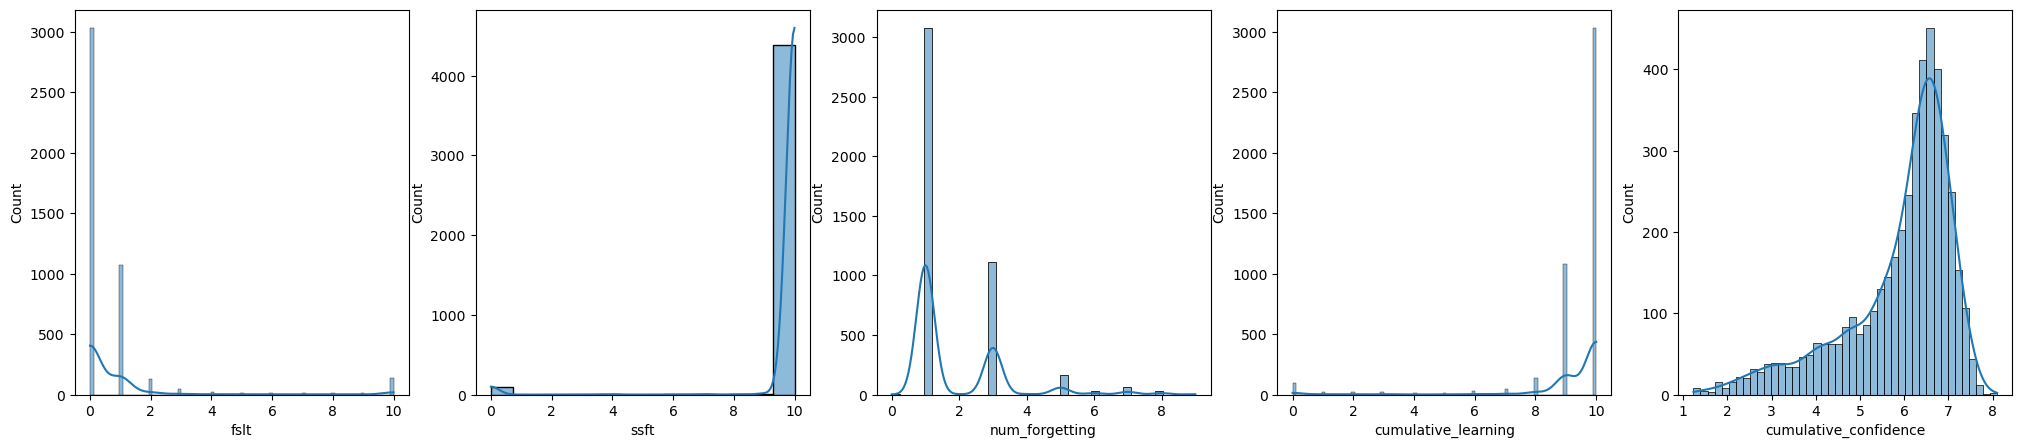

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for c in results.columns[1:]:
    sns.histplot(data=results, x=c, kde=True, ax=axs[results.columns.get_loc(c)-1])